A Neural Network predicting parameters from the maps.

This notebook loads in the results of that. **Compare `posterior_means` with the ground truth by analyzing the resulting scatterplot.**

In [1]:
import torch
import matplotlib.pyplot as plt
from hydra import compose, initialize

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parents[1]))

from maps_to_cosmology.encoder import Encoder
from maps_to_cosmology.datamodule import ConvergenceMapsModule

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initialize the config:

In [2]:
with initialize(config_path="../configs", version_base=None):
    cfg = compose("train_npe")

Instantiate the encoder using the checkpoint from a previous training run:

In [3]:
ckpt = "/data/scratch/blissWL_checkpoints/example_encoder.ckpt"
encoder = Encoder.load_from_checkpoint(ckpt)
encoder.eval()
encoder.to(device)

Encoder(
  (val_rmse): RootMeanSquaredError()
  (val_scatter): ScatterPlot()
  (test_rmse): RootMeanSquaredError()
  (test_scatter): ScatterPlot()
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=327680, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): SiLU()
    (5): Linear(in_features=128, out_features=12, bias=True)
  )
)

Instantiate the test dataloader:

In [4]:
# this cell takes approximately 3 minutes
datamodule = ConvergenceMapsModule(
    data_dir=cfg.paths.data_dir,
    batch_size=cfg.convergence_maps.batch_size,
    num_workers=cfg.convergence_maps.num_workers,
    val_split=cfg.convergence_maps.val_split,
    test_split=cfg.convergence_maps.test_split,
    seed=cfg.seed,
)
datamodule.setup()
test_loader = datamodule.test_dataloader()

Loading data:   0%|          | 0/6248 [00:00<?, ?it/s]

Loaded 99968 samples
Maps shape: torch.Size([99968, 256, 256, 5])
Params shape: torch.Size([99968, 6])
Train samples: 79976
Val samples: 9996
Test samples: 9996


Load in the convergence maps from the test set and evaluate the encoder on them. Also load the correspoding cosmological parameters from the test set:

In [5]:
posterior_means = []
posterior_stdevs = []
true_params = []

with torch.no_grad():
    for maps, params in test_loader:
        maps = maps.to(device)
        
        out = encoder(maps)
        posterior_mean = out[:, 0::2]
        posterior_means.append(posterior_mean.cpu())
        
        posterior_stdev = out[:, 1::2].clamp(-10, 10).exp().sqrt()
        posterior_stdevs.append(posterior_stdev.cpu())
        
        true_params.append(params)

posterior_means = torch.cat(posterior_means, dim=0)
posterior_stdevs = torch.cat(posterior_stdevs, dim=0)
true_params = torch.cat(true_params, dim=0)

For each of the six cosmological parameters, create a scatterplot of the true parameter value versus the posterior mean. You'll want to use `plt.scatter()`. Arrange the six scatterplots in a 2x3 grid. How accurately do the posterior means approximate the true values? Explain why.

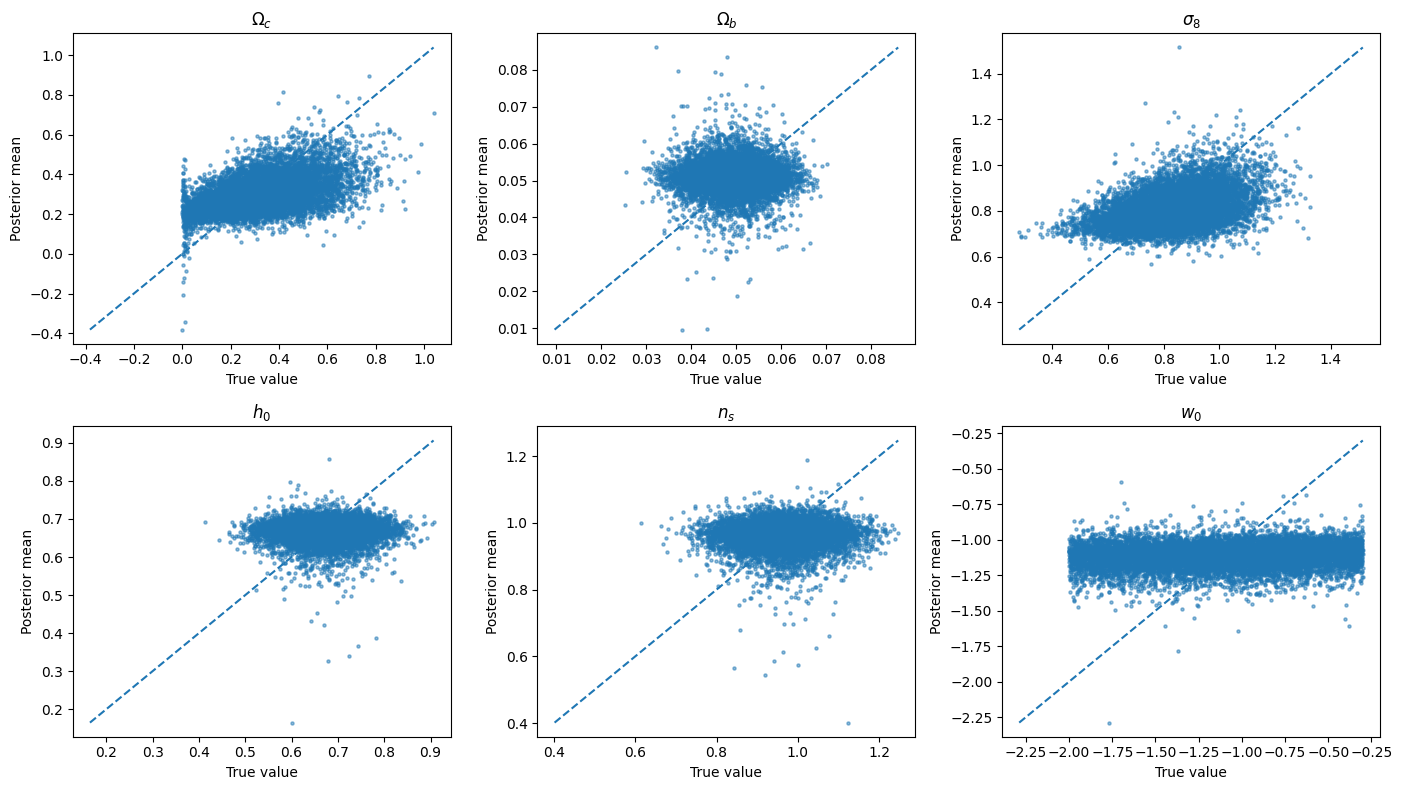

In [7]:
param_names = [
    r"$\Omega_c$", r"$\Omega_b$", r"$\sigma_8$",
    r"$h_0$", r"$n_s$", r"$w_0$"
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]

    x = true_params[:, i].numpy()
    y = posterior_means[:, i].numpy()

    ax.scatter(x, y, s=5, alpha=0.5)
    minv = min(x.min(), y.min())
    maxv = max(x.max(), y.max())
    ax.plot([minv, maxv], [minv, maxv], linestyle="--")

    ax.set_xlabel("True value")
    ax.set_ylabel("Posterior mean")
    ax.set_title(param_names[i])

plt.tight_layout()
plt.show()

### Observation
- `Clumpiness of matter` $\sigma_8$ is the best constrained parameter.
- $\Omega_c$ shows positive correlation with the true value.
- $w_0$ shows **almost no correlation** with the truth. Weak lensing maps cannot constrain it well.
- $\Omega_b$, $h_0$, and $n_s$ shows weak correlation with the true value.